In [54]:
import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from scipy import stats as st
import json
import re
from nltk.tokenize.regexp import WhitespaceTokenizer
from nltk import tokenize

In [55]:
GNI88 = pd.read_csv("/Users/carla/Desktop/internships/rethinkmedia/GNI88_cleaned_data.csv")

/Users/carla/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (9,10,24) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [56]:
GNI88 = GNI88[GNI88['Article Status']=='News'].reset_index(drop=True)
GNI88 = GNI88.drop(labels=329076, axis=0) #empty quote

In [57]:
# dictionary containing the classification groups for all speaker types
source_groups = {"Foreign Government": ['Foreign Gov/Mil Official'],
                "Experts": ['Nuke Organization','Non-Profit/NGO','Think Tanks',
                            'Nuke Organization - Other', 'Nuke Organization - Academic',
                            'International Orgs','Academic','Nuclear Scientist',"Analyst/Commentator",
                            'Attorney','Regulator'],
                "US Congress": ['US Rep. & Staff','US Senate & Staff', 'Partisans/Fmr. Politicians'],
                "US Federal Officials": ['Federal Official','State/Local Official',
                                        'Former Admin. Officials','Judicial Official'],
                "US Defense": ['US Military','Defense Forces','Defense'],
                "Media": ["Media/Journalist","Blogger"],
                "Corporate Official": ['Corporate Official'],
                "Other": ['Other','Chairman','Terrorist/Extremist','Information minister',
                          'Religious/Clerical', 'Ambassador', 'Nuclear Official',
                          'Citizen','Public Polling','US Police','Deputy']}

In [58]:
# Helper function that inverts a dictionary. This will be useful for using speaker groups
# later on in model evaluation
def invert_dict(dictionary):
  """Inputs:
     - dictionary: dict, dictionary we wish to invert
     Outputs:
     - dict, where keys are the initial dictionary's values and values are the initial dictionary's keys"""
  # get a list of all items in all dictionary values
  speaker_types = list(np.concatenate(list(dictionary.values())).flat)
  # each speaker type will become its own key now, and the value will be the speaker group it's a part of
  inverted_dict = {}
  for speaker_type in speaker_types:
    # find the group the speaker_type belongs in
    speaker_group = [key for key, value in dictionary.items() if speaker_type in value][0]
    # update the inverted dictionary such that the key is the speaker type and the value is the speaker group
    inverted_dict[speaker_type] = speaker_group
  return inverted_dict

In [59]:
source_to_group = invert_dict(source_groups)

In [60]:
def assign_source_to_group(source_type):
  """Inputs:
     - source_type: str, source type from quote datafame
     Outputs:
     - str of the bigger speaker category to which source_type belongs"""
  if type(source_type) != str:
    return "Other"
  try:
    return source_to_group[source_type]
  except:
    return "Other"

In [61]:
GNI88['Source Type'] = GNI88['Source Type'].apply(assign_source_to_group)

In [62]:
GNI88.head()

,artdate,Article ID,Headline,Quote ID,Article Status,Article Position,Messages,Submessages,Quote Position,Legacy Quote Tag,...,Constituent Group,Media Name,Media Medium,Journalist Name,Constituent Author,Article Issues,Custom Group,Media Group,fulltext,source_name_cleaned
0,2018-02-23,3777413,Can James Mattis Prevent Nuclear War With Nort...,7105520,News,Neutral,OLD Proliferation,OLD State Level Nuclear Programs,Neutral,NaN,...,None (Legacy Other),News Week,NaN,"Fryer-biggs, Zachary",NaN,NaN,NaN,NaN,Can James Mattis Prevent Nuclear War With Nort...,James Mattis
1,2018-02-23,3777413,Can James Mattis Prevent Nuclear War With Nort...,7105517,News,Neutral,OLD Proliferation,OLD State Level Nuclear Programs,Neutral,NaN,...,None (Legacy Other),News Week,NaN,"Fryer-biggs, Zachary",NaN,NaN,NaN,NaN,Can James Mattis Prevent Nuclear War With Nort...,James Mattis
2,2018-02-23,3777413,Can James Mattis Prevent Nuclear War With Nort...,7105518,News,Neutral,OLD Proliferation,OLD State Level Nuclear Programs,Positive,NaN,...,NaN,News Week,NaN,"Fryer-biggs, Zachary",NaN,NaN,NaN,NaN,Can James Mattis Prevent Nuclear War With Nort...,Leon E. Panetta
3,2018-02-23,3777413,Can James Mattis Prevent Nuclear War With Nort...,7105527,News,Neutral,OLD Proliferation,OLD State Level Nuclear Programs,Neutral,NaN,...,NaN,News Week,NaN,"Fryer-biggs, Zachary",NaN,NaN,NaN,NaN,Can James Mattis Prevent Nuclear War With Nort...,Chuck Hagel
4,2018-02-15,3777414,"For His Book 'Directorate S,' Journalist Steve...",7105525,News,Neutral,OLD Proliferation,OLD State Level Nuclear Programs,Positive,NaN,...,None (Legacy Other),NPR,NaN,"Kelly, Mary",NaN,NaN,NaN,NaN,"For His Book 'Directorate S,' Journalist Steve...",Steve Coll


### Subjectivity Feature Function

In [63]:
#Loading the MPQA Subjectivity Clues Lexicon (https://mpqa.cs.pitt.edu/lexicons/subj_lexicon/)
mpqa_dict = json.load(open("/Users/carla/Desktop/internships/rethinkmedia/mpqa_dict.json", "r"))

def get_subjectivity(art_str, mpqa_dict):
    subjectivity, adjectives, sub_adjectives = 0, 0, 0
    words = re.sub("[^\w]", " ",  art_str).split()
    
    for w in words:
        if w in mpqa_dict:  
            if mpqa_dict[w]['subj'] == 'weaksubj':
                subjectivity += 0.1
            if mpqa_dict[w]['subj'] == 'strongsubj':
                subjectivity += 1
            if mpqa_dict[w]['pos'] == 'adj' :
                adjectives += 1
                if mpqa_dict[w]['subj'] == 'weaksubj':
                    sub_adjectives += 0.1
                if mpqa_dict[w]['subj'] == 'strongsubj':
                    sub_adjectives += 1
    
    return subjectivity, sub_adjectives

### Sentiment Feature Function

### Idea1: divide paragraphs in sentences

In [64]:
vader = SentimentIntensityAnalyzer()

def sentence_vader(string):
    sentence_list = tokenize.sent_tokenize(string)
    score_list = []
    for sentence in sentence_list:
        score = vader.polarity_scores(sentence)
        score_list.append(score['compound'])
    return np.mean(score_list)

In [65]:
sentence_vader(GNI88['QText'][234016])

0.4036

In [80]:
GNI88_vader1 = GNI88.copy()
GNI88_vader1['Quote Sentiment Score'] = GNI88['QText'].apply(lambda x: sentence_vader(x))

In [81]:
GNI88_vader1.head()

,artdate,Article ID,Headline,Quote ID,Article Status,Article Position,Messages,Submessages,Quote Position,Legacy Quote Tag,...,Media Name,Media Medium,Journalist Name,Constituent Author,Article Issues,Custom Group,Media Group,fulltext,source_name_cleaned,Quote Sentiment Score
0,2018-02-23,3777413,Can James Mattis Prevent Nuclear War With Nort...,7105520,News,Neutral,OLD Proliferation,OLD State Level Nuclear Programs,Neutral,NaN,...,News Week,NaN,"Fryer-biggs, Zachary",NaN,NaN,NaN,NaN,Can James Mattis Prevent Nuclear War With Nort...,James Mattis,0.3182
1,2018-02-23,3777413,Can James Mattis Prevent Nuclear War With Nort...,7105517,News,Neutral,OLD Proliferation,OLD State Level Nuclear Programs,Neutral,NaN,...,News Week,NaN,"Fryer-biggs, Zachary",NaN,NaN,NaN,NaN,Can James Mattis Prevent Nuclear War With Nort...,James Mattis,0.0000
2,2018-02-23,3777413,Can James Mattis Prevent Nuclear War With Nort...,7105518,News,Neutral,OLD Proliferation,OLD State Level Nuclear Programs,Positive,NaN,...,News Week,NaN,"Fryer-biggs, Zachary",NaN,NaN,NaN,NaN,Can James Mattis Prevent Nuclear War With Nort...,Leon E. Panetta,-0.3546
3,2018-02-23,3777413,Can James Mattis Prevent Nuclear War With Nort...,7105527,News,Neutral,OLD Proliferation,OLD State Level Nuclear Programs,Neutral,NaN,...,News Week,NaN,"Fryer-biggs, Zachary",NaN,NaN,NaN,NaN,Can James Mattis Prevent Nuclear War With Nort...,Chuck Hagel,0.5348
4,2018-02-15,3777414,"For His Book 'Directorate S,' Journalist Steve...",7105525,News,Neutral,OLD Proliferation,OLD State Level Nuclear Programs,Positive,NaN,...,NPR,NaN,"Kelly, Mary",NaN,NaN,NaN,NaN,"For His Book 'Directorate S,' Journalist Steve...",Steve Coll,0.0876


In [82]:
print(np.mean(GNI88_vader1['Quote Sentiment Score']))
print(np.max(GNI88_vader1['Quote Sentiment Score']))
print(np.min(GNI88_vader1['Quote Sentiment Score']))
print(np.argmax(GNI88_vader1['Quote Sentiment Score']))
print(np.argmin(GNI88_vader1['Quote Sentiment Score']))

0.007077091577354983
0.982
-0.9895
52056
290017


In [83]:
print(GNI88_vader1['QText'][52056] + "\n")
print(GNI88_vader1['QText'][290017] + "\n")

We seek peace always as a country, as does Japan, but as you know and the United States knows, peace comes through strength and we will stand strongly with Japan and strongly with our allies for a peace and security in this region,

"A war with 15-kt weapons,"   or about the explosive force of the weapons deployed against Hiroshima and Nagasaki   "could lead to fatalities approximately equal to those worldwide in WWII and a war with 100-kt weapons could directly kill about 2.5 times as many as died worldwide in WWII, and in this nuclear war, the fatalities could occur in a single week,"



In [85]:
def sentiment_class(x):
    if x > 0:
        return "Positive"
    if x < 0:
        return "Negative"
    else: 
        return "Neutral"

GNI88_vader1['Quote Sentiment'] = GNI88_vader1['Quote Sentiment Score'].apply(lambda x: sentiment_class(x))

In [86]:
vader_FG = GNI88_vader1[GNI88_vader1['Source Type'] == 'Foreign Government']
vader_E = GNI88_vader1[GNI88_vader1['Source Type'] == 'Experts']
vader_UC = GNI88_vader1[GNI88_vader1['Source Type'] == 'US Congress']
vader_UF = GNI88_vader1[GNI88_vader1['Source Type'] == 'US Federal Officials']
vader_UD = GNI88_vader1[GNI88_vader1['Source Type'] == 'US Defense']
vader_M = GNI88_vader1[GNI88_vader1['Source Type'] == 'Media']
vader_CO = GNI88_vader1[GNI88_vader1['Source Type'] == 'Corporate Official']
vader_O = GNI88_vader1[GNI88_vader1['Source Type'] == 'Other']

0.01484532303790394


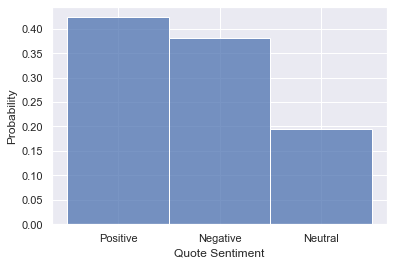

In [95]:
## Foreign Government

sns.set(style="darkgrid")
sns.set(font_scale=1)
sns.histplot(data=vader_FG, x='Quote Sentiment', stat = "probability", discrete=True) 
print(np.mean(vader_FG['Quote Sentiment Score']))

-0.013004982143749618


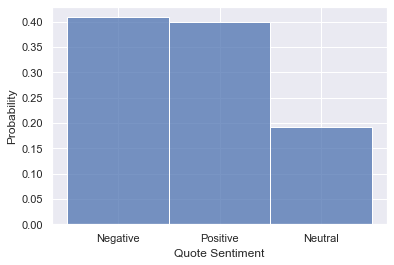

In [96]:
## Expert

sns.histplot(data=vader_E, x='Quote Sentiment', stat = "probability", discrete=True) 
print(np.mean(vader_E['Quote Sentiment Score']))

0.01704340577902237


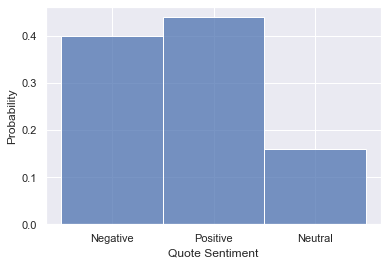

In [97]:
## US Congress

sns.histplot(data=vader_UC, x='Quote Sentiment', stat = "probability", discrete=True)
print(np.mean(vader_UC['Quote Sentiment Score']))

0.03852253379440918


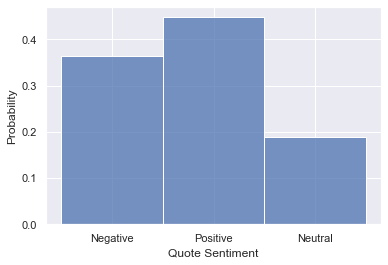

In [98]:
## US Federal Officials

sns.histplot(data=vader_UF, x='Quote Sentiment', stat = "probability", discrete=True)
print(np.mean(vader_UF['Quote Sentiment Score']))

-0.0019041375945658416


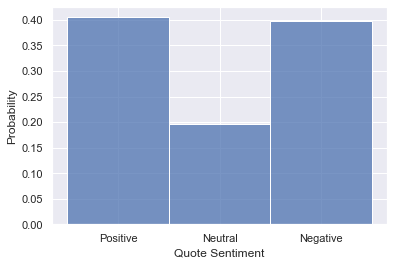

In [99]:
## US Defense

sns.histplot(data=vader_UD, x='Quote Sentiment', stat = "probability", discrete=True) 
print(np.mean(vader_UD['Quote Sentiment Score']))

-0.03063507626636084


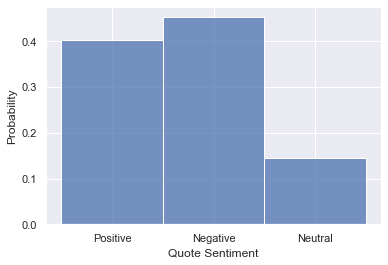

In [100]:
## Media

sns.histplot(data=vader_M, x='Quote Sentiment', stat = "probability", discrete=True) 
print(np.mean(vader_M['Quote Sentiment Score']))

0.05398238365744474


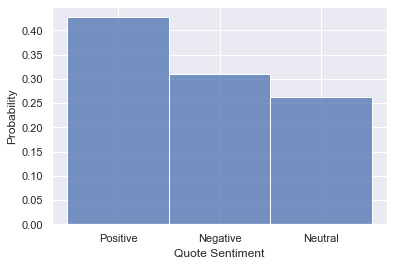

In [101]:
## Corporate Officials

sns.histplot(data=vader_CO, x='Quote Sentiment', stat = "probability", discrete=True) 
print(np.mean(vader_CO['Quote Sentiment Score']))

-0.08670464361301246


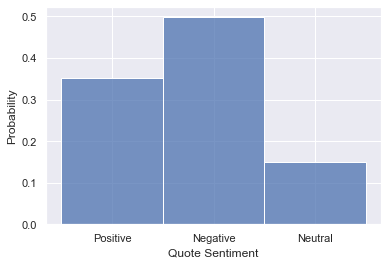

In [102]:
## Other

sns.histplot(data=vader_O, x='Quote Sentiment', stat = "probability", discrete=True) 
print(np.mean(vader_O['Quote Sentiment Score']))

In [103]:
## Foreign Goverment v.s all

FG = vader_FG['Quote Sentiment Score'].to_numpy()
st.ttest_ind(a=FG, b=GNI88_vader1['Quote Sentiment Score'].to_numpy(), equal_var=False)

Ttest_indResult(statistic=5.015869699180189, pvalue=5.285518204732463e-07)

In [104]:
## Expert v.s all

E = vader_E['Quote Sentiment Score'].to_numpy()
st.ttest_ind(a=E, b=GNI88_vader1['Quote Sentiment Score'].to_numpy(), equal_var=False)

Ttest_indResult(statistic=-11.778228619655735, pvalue=5.30431140671467e-32)

In [105]:
## US Congress v.s all

UC = vader_UC['Quote Sentiment Score'].to_numpy()
st.ttest_ind(a=UC, b=GNI88_vader1['Quote Sentiment Score'].to_numpy(), equal_var=False)

Ttest_indResult(statistic=4.289254986831861, pvalue=1.796564927318801e-05)

In [106]:
## US Federal Official v.s all

UF = vader_UF['Quote Sentiment Score'].to_numpy()
st.ttest_ind(a=UF, b=GNI88_vader1['Quote Sentiment Score'].to_numpy(), equal_var=False)

Ttest_indResult(statistic=20.66730254827444, pvalue=9.23579100091581e-95)

In [107]:
## US Defense v.s all

UD = vader_UD['Quote Sentiment Score'].to_numpy()
st.ttest_ind(a=UD, b=GNI88_vader1['Quote Sentiment Score'].to_numpy(), equal_var=False)

Ttest_indResult(statistic=-2.1269024470565348, pvalue=0.03345253235973856)

In [108]:
## Media v.s all

M = vader_M['Quote Sentiment Score'].to_numpy()
st.ttest_ind(a=M, b=GNI88_vader1['Quote Sentiment Score'].to_numpy(), equal_var=False)

Ttest_indResult(statistic=-16.760002335474073, pvalue=8.209547655441481e-63)

In [109]:
## Corporate Official v.s all

CO = vader_CO['Quote Sentiment Score'].to_numpy()
st.ttest_ind(a=CO, b=GNI88_vader1['Quote Sentiment Score'].to_numpy(), equal_var=False)

Ttest_indResult(statistic=8.453739562752462, pvalue=3.6683600647145937e-17)

In [110]:
## Other v.s all

O = vader_O['Quote Sentiment Score'].to_numpy()
st.ttest_ind(a=O, b=GNI88_vader1['Quote Sentiment Score'].to_numpy(), equal_var=False)

Ttest_indResult(statistic=-28.490920828960178, pvalue=4.559978151230584e-175)

### Idea2: truncate the paragraphs each 15 words

In [172]:
def vader_15(string):
    split_string = string.split(" ")
    length = len(split_string)
    sentence_list = []
    for i in range(length//15):
        sentence = " ".join(split_string[i*15:(i+1)*15])
        sentence_list.append(sentence)
    if length % 15 != 0:
        digit = length%15
        remainder = " ".join(split_string[-digit:])
        sentence_list.append(remainder)
    
    score_list = []
    for sentence in sentence_list:
        score = vader.polarity_scores(sentence)
        score_list.append(score['compound'])
    return np.mean(score_list)

In [173]:
vader_15(GNI88['QText'][234016])

0.3617916666666667

In [174]:
GNI88_vader2 = GNI88.copy()
GNI88_vader2['Quote Sentiment Score'] = GNI88['QText'].apply(lambda x: vader_15(x))

In [175]:
print(np.mean(GNI88_vader2['Quote Sentiment Score']))
print(np.max(GNI88_vader2['Quote Sentiment Score']))
print(np.min(GNI88_vader2['Quote Sentiment Score']))
print(np.argmax(GNI88_vader2['Quote Sentiment Score']))
print(np.argmin(GNI88_vader2['Quote Sentiment Score']))

0.0026282015326198915
0.94155
-0.945
91565
261015


In [176]:
print(GNI88_vader2['QText'][91565] + "\n")
print(GNI88_vader2['QText'][261015] + "\n")

His country like him. I like him. Love him. Love him. Guess what? Yes, yes, I love him. I love him. The guy is awesome.

I kill, I kill those who have killed my brother!



In [177]:
GNI88_vader2['Quote Sentiment'] = GNI88_vader2['Quote Sentiment Score'].apply(lambda x: sentiment_class(x))

In [178]:
vader_FG = GNI88_vader2[GNI88_vader2['Source Type'] == 'Foreign Government']
vader_E = GNI88_vader2[GNI88_vader2['Source Type'] == 'Experts']
vader_UC = GNI88_vader2[GNI88_vader2['Source Type'] == 'US Congress']
vader_UF = GNI88_vader2[GNI88_vader2['Source Type'] == 'US Federal Officials']
vader_UD = GNI88_vader2[GNI88_vader2['Source Type'] == 'US Defense']
vader_M = GNI88_vader2[GNI88_vader2['Source Type'] == 'Media']
vader_CO = GNI88_vader2[GNI88_vader2['Source Type'] == 'Corporate Official']
vader_O = GNI88_vader2[GNI88_vader2['Source Type'] == 'Other']

0.007048029321877197


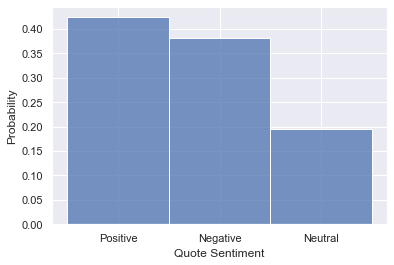

In [179]:
## Foreign Government

sns.set(style="darkgrid")
sns.set(font_scale=1)
sns.histplot(data=vader_FG, x='Quote Sentiment', stat = "probability", discrete=True) 
print(np.mean(vader_FG['Quote Sentiment Score']))

-0.009834045668854303


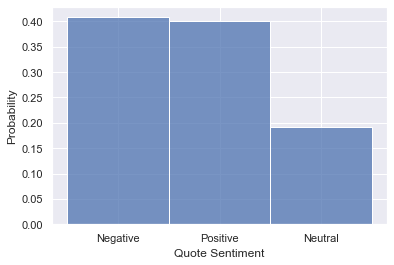

In [180]:
## Expert

sns.histplot(data=vader_E, x='Quote Sentiment', stat = "probability", discrete=True) 
print(np.mean(vader_E['Quote Sentiment Score']))

0.007481159603939562


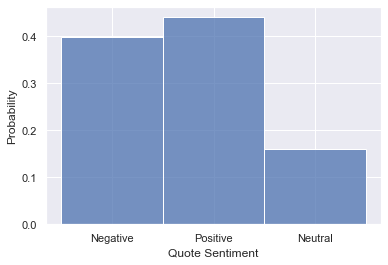

In [181]:
## US Congress

sns.histplot(data=vader_UC, x='Quote Sentiment', stat = "probability", discrete=True)
print(np.mean(vader_UC['Quote Sentiment Score']))

0.02240908437952389


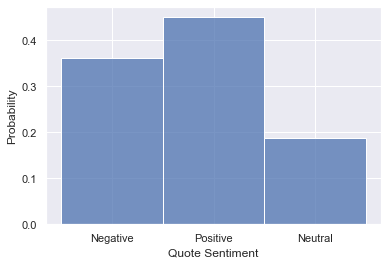

In [182]:
## US Federal Officials

sns.histplot(data=vader_UF, x='Quote Sentiment', stat = "probability", discrete=True)
print(np.mean(vader_UF['Quote Sentiment Score']))

-0.0018116396943822623


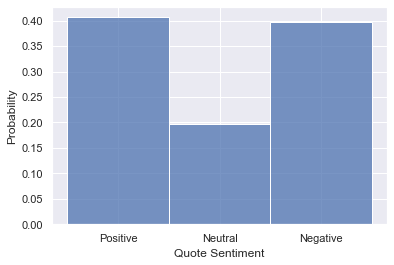

In [183]:
## US Defense

sns.histplot(data=vader_UD, x='Quote Sentiment', stat = "probability", discrete=True) 
print(np.mean(vader_UD['Quote Sentiment Score']))

-0.020456421942934053


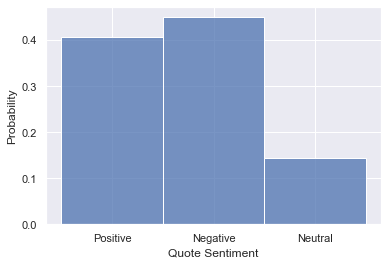

In [184]:
## Media

sns.histplot(data=vader_M, x='Quote Sentiment', stat = "probability", discrete=True) 
print(np.mean(vader_M['Quote Sentiment Score']))

0.031172418343475124


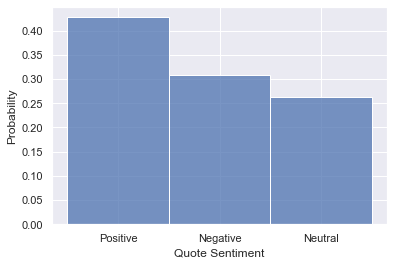

In [185]:
## Corporate Officials

sns.histplot(data=vader_CO, x='Quote Sentiment', stat = "probability", discrete=True) 
print(np.mean(vader_CO['Quote Sentiment Score']))

-0.05319668249917068


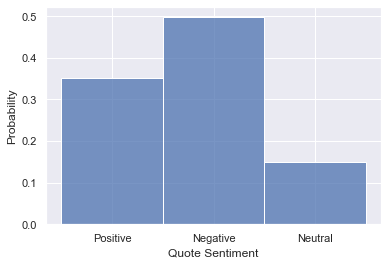

In [186]:
## Other

sns.histplot(data=vader_O, x='Quote Sentiment', stat = "probability", discrete=True) 
print(np.mean(vader_O['Quote Sentiment Score']))

In [189]:
## Foreign Goverment v.s all

FG = vader_FG['Quote Sentiment Score'].to_numpy()
st.ttest_ind(a=FG, b=GNI88_vader2['Quote Sentiment Score'].to_numpy(), equal_var=False)

Ttest_indResult(statistic=4.285921585571204, pvalue=1.8210026324120282e-05)

In [190]:
## Expert v.s all

E = vader_E['Quote Sentiment Score'].to_numpy()
st.ttest_ind(a=E, b=GNI88_vader2['Quote Sentiment Score'].to_numpy(), equal_var=False)

Ttest_indResult(statistic=-11.414425053864717, pvalue=3.694019801294893e-30)

In [191]:
## US Congress v.s all

UC = vader_UC['Quote Sentiment Score'].to_numpy()
st.ttest_ind(a=UC, b=GNI88_vader2['Quote Sentiment Score'].to_numpy(), equal_var=False)

Ttest_indResult(statistic=3.150554028709474, pvalue=0.0016307115769793987)

In [192]:
## US Federal Official v.s all

UF = vader_UF['Quote Sentiment Score'].to_numpy()
st.ttest_ind(a=UF, b=GNI88_vader2['Quote Sentiment Score'].to_numpy(), equal_var=False)

Ttest_indResult(statistic=19.87461496048787, pvalue=8.747709491245481e-88)

In [193]:
## US Defense v.s all

UD = vader_UD['Quote Sentiment Score'].to_numpy()
st.ttest_ind(a=UD, b=GNI88_vader2['Quote Sentiment Score'].to_numpy(), equal_var=False)

Ttest_indResult(statistic=-1.658170064631945, pvalue=0.0973143107297289)

In [194]:
## Media v.s all

M = vader_M['Quote Sentiment Score'].to_numpy()
st.ttest_ind(a=M, b=GNI88_vader2['Quote Sentiment Score'].to_numpy(), equal_var=False)

Ttest_indResult(statistic=-15.969140883641504, pvalue=3.261508828841866e-57)

In [195]:
## Corporate Official v.s all

CO = vader_CO['Quote Sentiment Score'].to_numpy()
st.ttest_ind(a=CO, b=GNI88_vader2['Quote Sentiment Score'].to_numpy(), equal_var=False)

Ttest_indResult(statistic=7.698116951320243, pvalue=1.656660948087668e-14)

In [196]:
## Other v.s all

O = vader_O['Quote Sentiment Score'].to_numpy()
st.ttest_ind(a=O, b=GNI88_vader2['Quote Sentiment Score'].to_numpy(), equal_var=False)

Ttest_indResult(statistic=-26.45784950765612, pvalue=1.145180138269566e-151)